# 0 - Requirements

In [1]:
import torch
import torchvision
from tqdm import tqdm
from sklearn.metrics import f1_score

import os
import matplotlib.pyplot as plt
from model.pytorch.ViT_model import ViT_model

In [2]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
__pyTorch VERSION: 1.9.1+cu102
__CUDA VERSION
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


# 1 - OCT dataset

In [3]:
# Parameters
device = 'cuda:0' if torch.cuda.is_available() else torch.device('cpu')
batch_size = 16
input_size = (128,128)
mean = .5
std = .5
num_classes = 4

In [4]:
# Load Dataset and Transform
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.Lambda(lambda x: x/255.)
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.Lambda(lambda x: x/255.)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.Lambda(lambda x: x/255.)
])

label_transform = torchvision.transforms.Lambda(lambda x: torch.as_tensor(x, dtype = torch.long))

image_dataset = {
    'train': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\train", train_transform, label_transform),
    'val': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\test", val_transform, label_transform),
    'test': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\val", test_transform, label_transform)
}

data_loader = {
    x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size,
                                    shuffle=True)
    for x in ['train', 'val', 'test']
}

# Identifications
label2idx = image_dataset['train'].class_to_idx
idx2label = {v:k for k,v in label2idx.items()}
dataset_sizes = {tag:len(data_loader[tag].dataset) for tag in ['train','val','test']}

Feature batch shape: torch.Size([16, 3, 128, 128])
Labels batch shape: torch.Size([16])


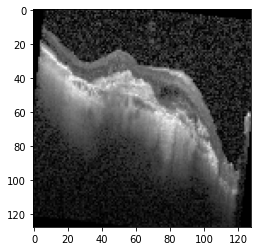

Label: CNV


In [5]:
# Display image and label.
train_features, train_labels = next(iter(data_loader['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(((img.permute(1,2,0).numpy()*std+mean)*255).astype('uint8'))
plt.show()
print(f"Label: {idx2label[label.item()]}")

# 2 - Training pipeline

In [6]:
# Model
model = ViT_model(depth = 2,
                  depth_te = 2,
                  linear_list = [4],
                  preprocessing = 'conv',
                  num_patches = 64,
                  patch_size = 16,
                  num_channels = 3,
                  hidden_dim = 128,
                  num_heads = 8,
                  attn_drop = .2,
                  proj_drop = .2,
                  linear_drop = .2,
                  dtype = None,
                  )
model.to(device)
#Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
lambda1 = lambda epoch: 0.75 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
print('Num. parameters:',sum(p.numel() for p in model.parameters()))

Architecture information:
Level 0:
	Patch size: 16
	Num. patches: 64
	Projection size: 768
	Hidden dim. size: 128
Level 1:
	Patch size: 8
	Num. patches: 256
	Projection size: 192
	Hidden dim. size: 64
Level 2:
	Patch size: 4
	Num. patches: 1024
	Projection size: 48
	Hidden dim. size: 32
Num. parameters: 2247883


In [7]:
epochs = 4
train_loss = 0
val_loss = 0
train_f1 = 0
val_f1 = 0
step = 0
print_verbose = 500
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Start training dataset
    print('Epoch:{}'.format(epoch+1))
    for inputs, labels in tqdm(data_loader['train']):
        # Computation
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Metrics
        train_f1 += f1_score(y_true = labels.cpu().numpy(),
                             y_pred = torch.argmax(logps, dim = -1).cpu().numpy(),
                             average = 'macro',
                             )
        # Verbose
        if step%print_verbose==0:
            print(f"After {step} batches:.. "
                    f"Train loss: {train_loss/step:.3f}.. "
                    f"Train f1: {train_f1/step:.3f}")
    
    # Start validation dataset
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader['val']):
            # Computation
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            val_loss += batch_loss.item()
            # Metrics
            val_f1 += f1_score(y_true = labels.cpu().numpy(),
                               y_pred = torch.argmax(logps, dim = -1).cpu().numpy(),
                               average = 'macro',
                               )
    train_losses.append(train_loss/len(data_loader['train']))
    val_losses.append(val_loss/len(data_loader['val']))
    # Metrics                    
    print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_loss/len(data_loader['train']):.3f}.. "
            f"Val loss: {val_loss/len(data_loader['val']):.3f}.. "
            f"Train f1: {train_f1/len(data_loader['train']):.3f}"
            f"Val f1: {val_f1/len(data_loader['val']):.3f}")
    train_loss = 0
    val_loss = 0
    train_f1 = 0
    val_f1 = 0
    strp = 0
    model.train()
#torch.save(model, 'aerialmodel.pth')

Epoch:1


 10%|▉         | 500/5218 [03:06<28:00,  2.81it/s]

After 500 steps:.. Train loss: 4.402.. Train f1: 0.173


 19%|█▉        | 1000/5218 [07:42<53:05,  1.32it/s]

After 1000 steps:.. Train loss: 3.196.. Train f1: 0.197


 29%|██▊       | 1500/5218 [12:04<22:55,  2.70it/s]

After 1500 steps:.. Train loss: 2.724.. Train f1: 0.204


 29%|██▉       | 1516/5218 [12:10<29:43,  2.08it/s]


KeyboardInterrupt: 